In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
save_dir = '/gdrive/My Drive/datasets/gan_images/'

In [3]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 적대적 생성 신경망

## 생성자

벡터(훈련하는 동안 잠재 공간에서 무작위로 샘플링)를 후보 이미지로 변환하는 `generator` 모델

In [ ]:
import keras
from keras import layers
import numpy as np

latent_dim = 32   # 32 차원 
height = 32
width = 32
channels = 3   # 컬러 

generator_input = keras.Input(shape=(latent_dim,))   # 함수형 API 사용 

# 입력을 16 × 16 크기의 128개 채널을 가진 특성맵으로 변환
x = layers.Dense(128 * 16 * 16)(generator_input)  # 처음엔 절반 크기로 만들어 냄 
x = layers.LeakyReLU()(x)  # ReLu 보다 학습을 잘하기 위해 사용 
x = layers.Reshape((16, 16, 128))(x)

# 합성곱 층을 추가
x = layers.Conv2D(256, 5, padding='same')(x)  # 필터 사용, 16, 16, 128 크기 
x = layers.LeakyReLU()(x)

# 32 × 32 크기로 업샘플링
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x) # 이미지 크기 증가 
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x) # 5 X 5 필터 
x = layers.LeakyReLU()(x)

# 32 × 32 크기의 1개 채널을 가진 특성 맵을 생성
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x) # 채널 갯수 3, 7 X 7 필터
generator = keras.models.Model(generator_input, x)  # (입력 , 출력) 모델 이름으 generator  
generator.summary()

## 판별자

후보 이미지(진짜 혹은 가짜)를 입력으로 받고 두 개의 클래스로 분류하는 `discriminator` 모델

In [5]:
discriminator_input = layers.Input(shape=(height          # 32
                                          , width         # 32
                                          , channels))    # 3
x = layers.Conv2D(128, 3)(discriminator_input) # 128 필터, 4X4 필터 사용 
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)    # 평탄화 

# 드롭아웃 층을 넣는 것이 아주 중요
x = layers.Dropout(0.4)(x)   # 학습에 중요 

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)  # 0인지 1인지 분류 

discriminator = keras.models.Model(discriminator_input, x) # (이미지 입력 , 아웃풋)
discriminator.summary()

# 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑을 사용
# 안정된 훈련을 위해서 학습률 감쇠를 사용합니다
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008
                                                   , clipvalue=1.0   # 미분에 기준값(임계값) - 클리핑 
                                                   , decay=1e-8)     # 감쇠률 
discriminator.compile(optimizer=discriminator_optimizer
                      , loss='binary_crossentropy')   # T/F 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0         
__________

## 적대적 네트워크

생성자와 판별자를 연결하여 GAN을 설정

In [0]:
# 판별자의 가중치가 훈련되지 않도록 설정(gan 모델에만 적용)
discriminator.trainable = False  # 판변자는 훈련 안되도록 

gan_input = keras.Input(shape=(latent_dim,))      # 랜텀한 노이즈 사용 - 입력 
gan_output = discriminator(generator(gan_input))  # 출력 
gan = keras.models.Model(gan_input, gan_output)   # 32 입력 

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004
                                         , clipvalue=1.0
                                         , decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy') # 0 / 1 의 값 

## DCGAN 훈련

In [7]:
import os
from keras.preprocessing import image

# CIFAR10 데이터를 로드
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()    # 이미지 불러오기 - 테스트 data 없음 

# 개구리 이미지를 선택(클래스 6)
x_train = x_train[y_train.flatten() == 6] 

# 데이터를 정규화
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255. # 데이터 건수, h, w, ch 4차원 형태   

iterations = 10000
batch_size = 20
#save_dir = './datasets/gan_images/'


if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# 훈련 반복 시작
start = 0
for step in range(iterations):
    # 잠재 공간에서 무작위로 포인트를 샘플링
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim)) # 20, 30 

    # 가짜 이미지를 디코딩
    generated_images = generator.predict(random_latent_vectors)  # 네트웍을 통과한 값이 나옴 

    # 진짜 이미지와 연결
    stop = start + batch_size  
    real_images = x_train[start: stop] # 0 : 20 
    combined_images = np.concatenate([generated_images, real_images]) # 합성 이미지 작성 

    # 진짜와 가짜 이미지를 구분하여 레이블을 합침
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # 레이블에 랜덤 노이즈를 추가합니다.중요
    labels += 0.05 * np.random.random(labels.shape) # 라벨에 값 추가 

    # discriminator를 훈련
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # 잠재 공간에서 무작위로 포인트를 샘플링
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 모두 “진짜 이미지"라고 레이블을 만듬
    misleading_targets = np.zeros((batch_size, 1))

    # generator를 훈련(gan 모델에서 discriminator의 가중치는 동결)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets) 
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # 중간 중간 저장하고 그래프를 그림
    if step % 100 == 0:
        # 모델 가중치를 저장
        gan.save_weights('gan.h5')

        # 측정 지표를 출력 --> 0이 되도록 학습 
        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

        # 생성된 이미지 하나를 저장
        img = image.array_to_img(generated_images[0] * 255., scale=False)  # 환원하기 위해 255 곱하기 
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 비교를 위해 진짜 이미지 하나를 저장
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

170500096/170498071 [==============================] - 22s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


스텝 0에서 판별자 손실: 0.6941486
스텝 0에서 적대적 손실: 0.6568805
스텝 100에서 판별자 손실: 0.67833567
스텝 100에서 적대적 손실: 0.831689
스텝 200에서 판별자 손실: 0.6999217
스텝 200에서 적대적 손실: 0.75685483
스텝 300에서 판별자 손실: 0.7101194
스텝 300에서 적대적 손실: 0.75819105
스텝 400에서 판별자 손실: 0.6891945
스텝 400에서 적대적 손실: 0.788787
스텝 500에서 판별자 손실: 0.7071129
스텝 500에서 적대적 손실: 0.7621411
스텝 600에서 판별자 손실: 0.6980983
스텝 600에서 적대적 손실: 0.7594789
스텝 700에서 판별자 손실: 0.6964201
스텝 700에서 적대적 손실: 0.75457066
스텝 800에서 판별자 손실: 0.6920296
스텝 800에서 적대적 손실: 0.7440341
스텝 900에서 판별자 손실: 0.68909407
스텝 900에서 적대적 손실: 0.7473227
스텝 1000에서 판별자 손실: 0.7038557
스텝 1000에서 적대적 손실: 0.82488185
스텝 1100에서 판별자 손실: 0.6836839
스텝 1100에서 적대적 손실: 0.7779158
스텝 1200에서 판별자 손실: 0.6800066
스텝 1200에서 적대적 손실: 0.77444494
스텝 1300에서 판별자 손실: 0.69509375
스텝 1300에서 적대적 손실: 0.7239984
스텝 1400에서 판별자 손실: 0.6999341
스텝 1400에서 적대적 손실: 0.7851838
스텝 1500에서 판별자 손실: 0.691013
스텝 1500에서 적대적 손실: 0.6927365
스텝 1600에서 판별자 손실: 0.7186498
스텝 1600에서 적대적 손실: 0.763687
스텝 1700에서 판별자 손실: 0.691965
스텝 1700에서 적대적 손실: 0.73221457
스텝 1800에서 판별

가짜 이미지 출력

In [0]:
import matplotlib.pyplot as plt

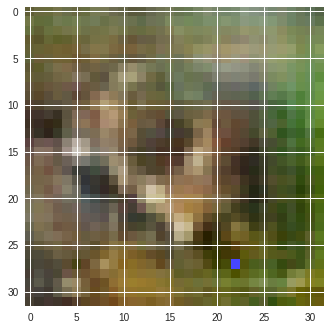

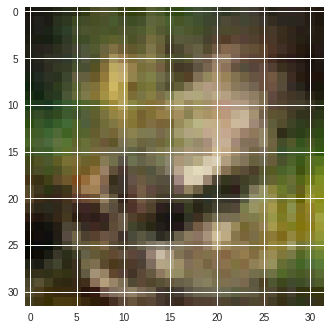

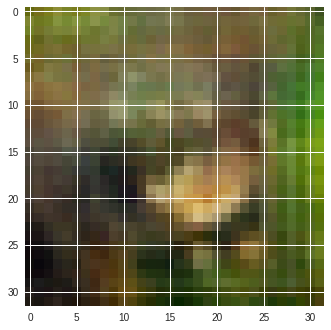

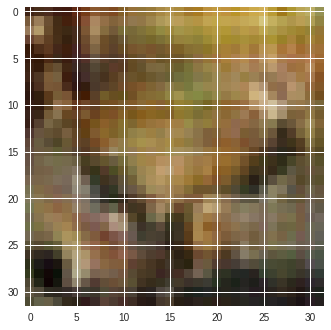

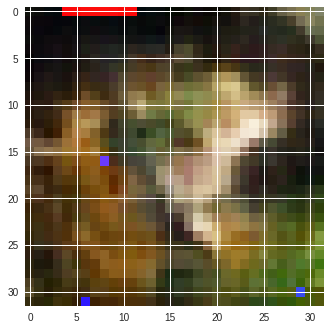

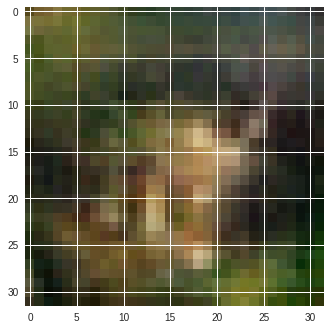

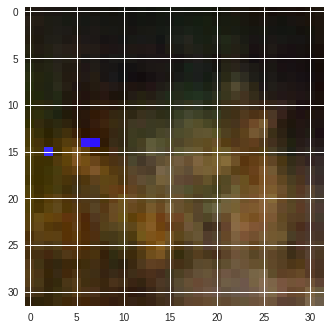

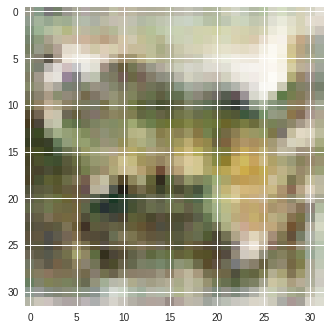

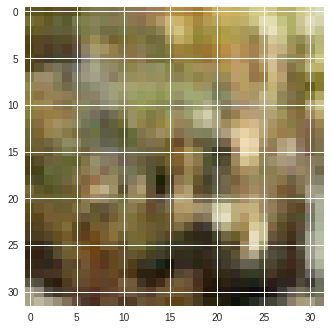

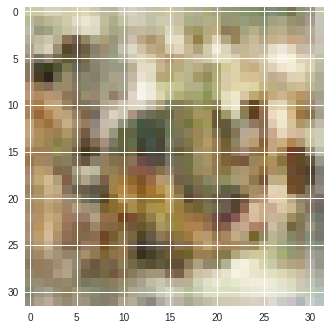

In [9]:
# 잠재 공간에서 랜덤한 포인트를 샘플링
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 가짜 이미지로 디코딩
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

Froggy with some pixellated artifacts.